<a href="https://colab.research.google.com/github/Xander2580/SecondRepo/blob/main/last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install pandas openpyxl scikit-learn imbalanced-learn nltk tensorflow==2.19.0

# (B) Imports & basic config
import os, re, random, math, json, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)

from imblearn.over_sampling import RandomOverSampler

# (C) Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# (D) GPU check
print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# (E) Plotting defaults
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True


TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load dataset from ZIP, merge, clean, and quick EDA

In [ ]:
import zipfile
from io import BytesIO

ZIP_PATH = "/content/drive/MyDrive/ColabNotebooks/yelpNYC.zip"

# Read Excel files inside the ZIP ====
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    # list files to be sure:
    print("ZIP contents:", z.namelist())
    with z.open("Yelp Metadata.xlsx") as f_meta:
        meta_bytes = f_meta.read()
    with z.open("Yelp dataset.xlsx") as f_data:
        data_bytes = f_data.read()

import pandas as pd
meta_xls = pd.ExcelFile(BytesIO(meta_bytes))
data_xls = pd.ExcelFile(BytesIO(data_bytes))

print("Sheets (Metadata):", meta_xls.sheet_names)
print("Sheets (Dataset) :", data_xls.sheet_names)

# We’ll use Sheet2 based on your file structure
meta_df = meta_xls.parse("Sheet2")
data_df = data_xls.parse("Sheet2")

# Basic sanity cleanup ====
# Keep only the columns we need and ensure "Review_id" is present in both
need_meta_cols = ["Review_id", "Product_id", "Rating", "Label", "Review_Date"]
need_data_cols = ["Review_id", "Product_id", "Review_Date", "Review_Text"]

meta_df = meta_df[need_meta_cols].copy()
data_df = data_df[need_data_cols].copy()

# Drop obvious junk
meta_df = meta_df.dropna(subset=["Review_id", "Label"]).drop_duplicates(subset=["Review_id"])
data_df = data_df.dropna(subset=["Review_id", "Review_Text"]).drop_duplicates(subset=["Review_id"])

ZIP contents: ['Yelp Metadata.xlsx', 'Yelp dataset.xlsx']
Sheets (Metadata): ['Sheet2', 'Sheet1']
Sheets (Dataset) : ['Sheet2', 'Sheet1']


In [ ]:
# Merge on Review_id ====
df = pd.merge(meta_df, data_df[["Review_id", "Review_Text"]], on="Review_id", how="inner")

# Keep only rows with non-empty text
df["Review_Text"] = df["Review_Text"].astype(str).str.strip()
df = df[df["Review_Text"].str.len() > 0].reset_index(drop=True)

print("\nMerged shape:", df.shape)
print(df.head(3))


Merged shape: (160225, 6)
   Review_id  Product_id  Rating  Label Review_Date  \
0        923           0       3     -1  2014-12-08   
1        924           0       3     -1  2013-05-16   
2        925           0       4     -1  2013-07-01   

                                         Review_Text  
0  The food at snack is a selection of popular Gr...  
1  This little place in Soho is wonderful. I had ...  
2  ordered lunch for 15 from Snack last Friday. Â...  


In [ ]:
# Class distribution
label_counts = df["Label"].value_counts().sort_index()
print("\nLabel counts:\n", label_counts)

# Text length stats
df["text_len"] = df["Review_Text"].str.split().apply(len)
print("\nText length (words) — describe():\n", df["text_len"].describe())

# A few examples from each class
def peek_class(c, n=2):
    print(f"\n=== Samples for Label {c} ===")
    print(df.loc[df["Label"]==c, ["Review_id","Rating","Review_Date","text_len","Review_Text"]].head(n))

peek_class(1, n=3)   # likely genuine
peek_class(-1, n=3)  # likely fake



Label counts:
 Label
-1     28071
 1    132154
Name: count, dtype: int64

Text length (words) — describe():
 count    160225.000000
mean        102.687564
std          98.581909
min           1.000000
25%          38.000000
50%          74.000000
75%         134.000000
max        1036.000000
Name: text_len, dtype: float64

=== Samples for Label 1 ===
    Review_id  Rating Review_Date  text_len  \
14        937       4  2014-10-15        11   
15        938       5  2014-10-10        29   
16        939       3  2014-10-03       179   

                                          Review_Text  
14  Tiny little place, but very good food. Pastits...  
15  I had the braised lamb sandwich and was one of...  
16  This spot is close to my job so I decided to c...  

=== Samples for Label -1 ===
   Review_id  Rating Review_Date  text_len  \
0        923       3  2014-12-08        40   
1        924       3  2013-05-16        52   
2        925       4  2013-07-01        34   

                  

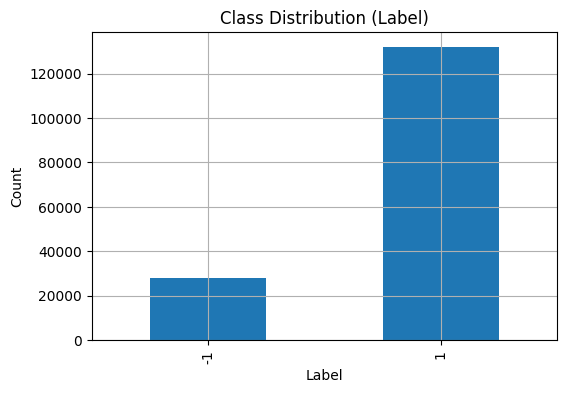

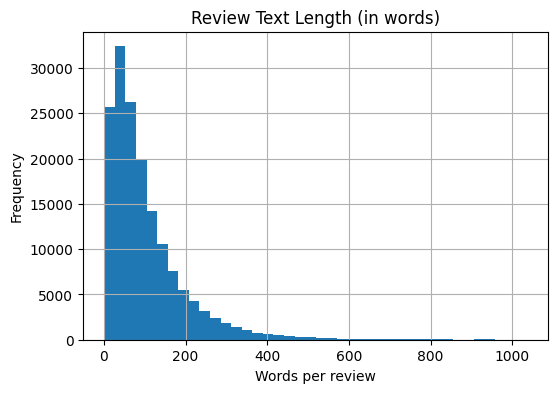


Saved merged dataframe to /content/merged_reviews.pkl


In [ ]:
# (Optional) Quick plots
import matplotlib.pyplot as plt

plt.figure()
label_counts.plot(kind="bar")
plt.title("Class Distribution (Label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure()
df["text_len"].hist(bins=40)
plt.title("Review Text Length (in words)")
plt.xlabel("Words per review")
plt.ylabel("Frequency")
plt.show()

# Save merged for later steps (to avoid re-reading)
df = df.drop(columns=["text_len"])
df.to_pickle("/content/merged_reviews.pkl")
print("\nSaved merged dataframe to /content/merged_reviews.pkl")

Split dataset and apply Random Oversampling on the training set only

In [ ]:
# Load the merged dataframe
df = pd.read_pickle("/content/merged_reviews.pkl")

# Separate features and target
X = df["Review_Text"].values
y = df["Label"].values

# Train/Val/Test split — 70% train, 15% val, 15% test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


Train size: 112157
Val size: 24034
Test size: 24034


In [ ]:
# Apply Random Oversampling to the training set
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=SEED)

# Need 2D input for fit_resample, so reshape temporarily
X_train_reshaped = X_train.reshape(-1, 1)
X_train_bal, y_train_bal = ros.fit_resample(X_train_reshaped, y_train)
X_train_bal = X_train_bal.ravel()  # back to 1D

# Check new balance
from collections import Counter
print("\nClass balance (train before):", Counter(y_train))
print("Class balance (train after) :", Counter(y_train_bal))
print("Val balance:", Counter(y_val))
print("Test balance:", Counter(y_test))



Class balance (train before): Counter({np.int64(1): 92507, np.int64(-1): 19650})
Class balance (train after) : Counter({np.int64(1): 92507, np.int64(-1): 92507})
Val balance: Counter({np.int64(1): 19824, np.int64(-1): 4210})
Test balance: Counter({np.int64(1): 19823, np.int64(-1): 4211})


In [ ]:
# Save split datasets for next steps
np.savez("/content/dataset_splits.npz",
         X_train=X_train_bal, y_train=y_train_bal,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

print("\nSaved balanced splits to /content/dataset_splits.npz")


Saved balanced splits to /content/dataset_splits.npz


In [ ]:
# SANITY CHECK — verify the merge integrity across the full dataset

import zipfile
import pandas as pd
from io import BytesIO

ZIP_PATH = "/content/drive/MyDrive/ColabNotebooks/yelpNYC.zip"  # adjust if needed

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    with z.open("Yelp Metadata.xlsx") as f_meta:
        meta_bytes = f_meta.read()
    with z.open("Yelp dataset.xlsx") as f_data:
        data_bytes = f_data.read()

# Read only needed columns (faster) and normalize dtypes
meta = pd.read_excel(BytesIO(meta_bytes), sheet_name="Sheet2", engine="openpyxl",
                     usecols=["Review_id","Product_id","Review_Date","Rating","Label"])
data = pd.read_excel(BytesIO(data_bytes), sheet_name="Sheet2", engine="openpyxl",
                     usecols=["Review_id","Product_id","Review_Date","Review_Text"])

# Basic cleanup
meta = meta.dropna(subset=["Review_id"]).drop_duplicates(subset=["Review_id"]).copy()
data = data.dropna(subset=["Review_id"]).drop_duplicates(subset=["Review_id"]).copy()

# Merge for comparison
cmp = pd.merge(meta, data, on="Review_id", suffixes=("_meta","_data"), how="inner")

# Normalize dates to datetime (ignoring time zone)
meta_dates = pd.to_datetime(cmp["Review_Date_meta"], errors="coerce")
data_dates = pd.to_datetime(cmp["Review_Date_data"], errors="coerce")

# Find mismatches
prod_mismatch = cmp[cmp["Product_id_meta"] != cmp["Product_id_data"]][
    ["Review_id","Product_id_meta","Product_id_data"]
]
date_mismatch = cmp[meta_dates != data_dates][
    ["Review_id","Review_Date_meta","Review_Date_data"]
]

# Find missing ids either side
meta_ids = set(meta["Review_id"].tolist())
data_ids = set(data["Review_id"].tolist())
missing_in_text = len(meta_ids - data_ids)
missing_in_meta = len(data_ids - meta_ids)

print("=== MERGE SANITY REPORT ===")
print("Total rows in META:", len(meta))
print("Total rows in TEXT:", len(data))
print("Rows after inner-merge:", len(cmp))
print("Missing in TEXT file (present in META only):", missing_in_text)
print("Missing in META file (present in TEXT only):", missing_in_meta)
print("Product_id mismatches:", len(prod_mismatch))
print("Review_Date mismatches:", len(date_mismatch))

if len(prod_mismatch) > 0:
    print("\nSample Product_id mismatches:")
    display(prod_mismatch.head(10))

if len(date_mismatch) > 0:
    print("\nSample Review_Date mismatches:")
    display(date_mismatch.head(10))

# Optional hard assertions (uncomment to enforce)
# assert missing_in_text == 0, "There are Review_id(s) missing in TEXT file."
# assert missing_in_meta == 0, "There are Review_id(s) missing in META file."
# assert len(prod_mismatch) == 0, "Product_id mismatch found."
# assert len(date_mismatch) == 0, "Review_Date mismatch found."


=== MERGE SANITY REPORT ===
Total rows in META: 160225
Total rows in TEXT: 160225
Rows after inner-merge: 160225
Missing in TEXT file (present in META only): 0
Missing in META file (present in TEXT only): 0
Product_id mismatches: 0
Review_Date mismatches: 0


Text cleaning, tokenization, and padding

In [ ]:
import re, json, pickle, numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the balanced splits
splits = np.load("/content/dataset_splits.npz", allow_pickle=True)
X_train_raw = splits["X_train"]
y_train_raw = splits["y_train"]
X_val_raw   = splits["X_val"]
y_val_raw   = splits["y_val"]
X_test_raw  = splits["X_test"]
y_test_raw  = splits["y_test"]

print("Loaded:",
      len(X_train_raw), "train,", len(X_val_raw), "val,", len(X_test_raw), "test")

# Map labels {-1, 1} -> {0, 1}
def map_labels(arr):
    arr = np.array(arr, dtype=int)
    return np.where(arr == 1, 1, 0)

y_train = map_labels(y_train_raw)
y_val   = map_labels(y_val_raw)
y_test  = map_labels(y_test_raw)

print("Label mapping check — unique:", np.unique(y_train, return_counts=True))

Loaded: 185014 train, 24034 val, 24034 test
Label mapping check — unique: (array([0, 1]), array([92507, 92507]))


In [ ]:
# Lightweight text cleaner (keeps words and basic punctuation)
URL_RE   = re.compile(r"https?://\S+|www\.\S+")
HTML_RE  = re.compile(r"<.*?>")
EMOJI_RE = re.compile("[^\w\s.,!?\'\-:/()]")  # remove non-basic symbols
WS_RE    = re.compile(r"\s+")

def clean_text(t: str) -> str:
    if not isinstance(t, str):
        t = str(t)
    t = t.lower()
    t = URL_RE.sub(" ", t)
    t = HTML_RE.sub(" ", t)
    t = EMOJI_RE.sub(" ", t)
    t = t.replace("&amp;", "and").replace("&nbsp;", " ")
    t = WS_RE.sub(" ", t).strip()
    return t

X_train = np.array([clean_text(t) for t in X_train_raw], dtype=object)
X_val   = np.array([clean_text(t) for t in X_val_raw], dtype=object)
X_test  = np.array([clean_text(t) for t in X_test_raw], dtype=object)

print("Example cleaned text:", X_train[0][:120], "...")

Example cleaned text: best filipino food in manhattan. â all of the stock filipino dishes are covered well, and you can expect great tocino, a ...


In [ ]:
# Tokenizer — build on TRAIN ONLY (avoid leakage)
VOCAB_LIMIT = 50000           # can tune later
tokenizer = Tokenizer(num_words=VOCAB_LIMIT, oov_token="[OOV]")
tokenizer.fit_on_texts(X_train)

# Save tokenizer for inference
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Text → integer sequences
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq   = tokenizer.texts_to_sequences(X_val)
test_seq  = tokenizer.texts_to_sequences(X_test)

# Compute a reasonable max length from TRAIN distribution (95th percentile)
lengths = np.array([len(s) for s in train_seq if len(s) > 0])
if len(lengths) == 0:
    raise ValueError("All training sequences are empty after cleaning.")
p95 = int(np.percentile(lengths, 95))
MAX_LEN = max(50, min(p95, 400))   # clamp to [50, 400] to be robust

print(f"Seq length stats — mean={lengths.mean():.1f}, median={np.median(lengths):.1f}, p95={p95}, MAX_LEN used={MAX_LEN}")

Seq length stats — mean=96.5, median=68.0, p95=279, MAX_LEN used=279


In [ ]:
# Pad sequences
X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

print("Shapes:",
      "\n  X_train_pad", X_train_pad.shape,
      "\n  X_val_pad  ", X_val_pad.shape,
      "\n  X_test_pad ", X_test_pad.shape)

# Save preprocessed arrays for the next step
np.savez("/content/seq_data.npz",
         X_train=X_train_pad, y_train=y_train,
         X_val=X_val_pad,     y_val=y_val,
         X_test=X_test_pad,   y_test=y_test,
         max_len=MAX_LEN)

meta = {
    "vocab_size": min(VOCAB_LIMIT, len(tokenizer.word_index) + 1),
    "max_len": int(MAX_LEN)
}
with open("/content/preproc_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("\nSaved:")
print("  /content/tokenizer.pkl")
print("  /content/seq_data.npz")
print("  /content/preproc_meta.json  ->", meta)


Shapes: 
  X_train_pad (185014, 279) 
  X_val_pad   (24034, 279) 
  X_test_pad  (24034, 279)

Saved:
  /content/tokenizer.pkl
  /content/seq_data.npz
  /content/preproc_meta.json  -> {'vocab_size': 50000, 'max_len': 279}


Build BiLSTM model (regularized) + callbacks

In [ ]:
import json, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# Load preprocessed data/meta
meta = json.load(open("/content/preproc_meta.json"))
SEQ = np.load("/content/seq_data.npz")

X_train = SEQ["X_train"]; y_train = SEQ["y_train"]
X_val   = SEQ["X_val"];   y_val   = SEQ["y_val"]
X_test  = SEQ["X_test"];  y_test  = SEQ["y_test"]

VOCAB_SIZE = int(meta["vocab_size"])
MAX_LEN    = int(meta["max_len"])

print("VOCAB_SIZE:", VOCAB_SIZE, "| MAX_LEN:", MAX_LEN)
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

VOCAB_SIZE: 50000 | MAX_LEN: 279
Train: (185014, 279)  Val: (24034, 279)  Test: (24034, 279)


In [ ]:
# Model hyperparameters
EMBED_DIM   = 128            # try 200 for even stronger capacity if GPU allows
LSTM_UNITS1 = 128
LSTM_UNITS2 = 64
DROP_EMB    = 0.20
DROP_LSTM   = 0.25
DROP_DENSE  = 0.30
L2_MAIN     = 1e-4
L2_RNN      = 1e-5
LR          = 2e-3

# Architecture
inp = layers.Input(shape=(MAX_LEN,), name="text")

x = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBED_DIM,
    mask_zero=True,
    name="embed"
)(inp)

x = layers.SpatialDropout1D(DROP_EMB, name="spatial_dropout")(x)

x = layers.Bidirectional(
    layers.LSTM(
        LSTM_UNITS1,
        return_sequences=True,
        dropout=DROP_LSTM,
        recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(L2_RNN),
        use_cudnn=False, # Disable CuDNN
        name="lstm1"
    ),
    name="bilstm1"
)(x)

x = layers.Bidirectional(
    layers.LSTM(
        LSTM_UNITS2,
        return_sequences=True,
        dropout=DROP_LSTM,
        recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(L2_RNN),
        use_cudnn=False, # Disable CuDNN
        name="lstm2"
    ),
    name="bilstm2"
)(x)

In [ ]:
# Dual pooling (captures both salient spikes and overall context)
max_p = layers.GlobalMaxPooling1D(name="gmp")(x)
avg_p = layers.GlobalAveragePooling1D(name="gap")(x)
x = layers.Concatenate(name="concat_pool")([max_p, avg_p])

x = layers.BatchNormalization(name="bn")(x)
x = layers.Dropout(0.40, name="drop_bn")(x)

x = layers.Dense(128, activation="relu",
                 kernel_regularizer=regularizers.l2(L2_MAIN),
                 name="dense_relu")(x)
x = layers.Dropout(DROP_DENSE, name="drop_dense")(x)

out = layers.Dense(1, activation="sigmoid", name="out")(x)

model = models.Model(inp, out, name="BiLSTM_FakeReview")

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

model.summary()

Model: "BiLSTM_FakeReview"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 279)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 279, 128)  │  6,400,000 │ text[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout     │ (None, 279, 128)  │          0 │ embed[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 279)       │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm1             │ (None, 279, 256)  │    263,168 │ spatial_dropout[… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm2             │ (None, 279, 128)  │    164,352 │ bilstm1[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp                 │ (None, 128)       │          0 │ bilstm2[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 128)       │          0 │ bilstm2[0][0],    │
│ (GlobalAveragePool… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_pool         │ (None, 256)       │          0 │ gmp[0][0],        │
│ (Concatenate)       │                   │            │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn                  │ (None, 256)       │      1,024 │ concat_pool[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_bn (Dropout)   │ (None, 256)       │          0 │ bn[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu (Dense)  │ (None, 128)       │     32,896 │ drop_bn[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dense          │ (None, 128)       │          0 │ dense_relu[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │        129 │ drop_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,861,569 (26.17 MB)

 Trainable params: 6,861,057 (26.17 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Callbacks — monitor AUC (more informative on imbalance)
early = callbacks.EarlyStopping(
    monitor="val_auc", mode="max",
    patience=3, min_delta=1e-4,
    restore_best_weights=True, verbose=1
)
plateau = callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max",
    factor=0.5, patience=2, min_lr=1e-5, verbose=1
)
ckpt = callbacks.ModelCheckpoint(
    "/content/bilstm_best.keras",
    monitor="val_auc", mode="max",
    save_best_only=True, verbose=1
)
csv = callbacks.CSVLogger("/content/training_log.csv", append=False)

print("\nModel ready. Next step will start training.")


Model ready. Next step will start training.


In [ ]:
# VERIFY BALANCING — loads splits saved and prints class counts

import numpy as np
from collections import Counter

splits = np.load("/content/dataset_splits.npz", allow_pickle=True)

X_train = splits["X_train"]         # balanced texts (after ROS)
y_train = splits["y_train"]         # balanced labels
X_val   = splits["X_val"]
y_val   = splits["y_val"]
X_test  = splits["X_test"]
y_test  = splits["y_test"]

print("Shapes:")
print("  X_train:", len(X_train), "  X_val:", len(X_val), "  X_test:", len(X_test))

def counts(name, y):
    c = Counter(y.tolist())
    print(f"{name} counts:", dict(sorted(c.items())))

counts("TRAIN (should be balanced)", y_train)
counts("VAL   (original distribution)", y_val)
counts("TEST  (original distribution)", y_test)

# Optional: map {-1,1} -> {0,1} and re-check
y_train_bin = np.where(y_train==1, 1, 0)
y_val_bin   = np.where(y_val==1,   1, 0)
y_test_bin  = np.where(y_test==1,  1, 0)

print("\nAfter mapping to {0,1}:")
counts("TRAIN (balanced)", y_train_bin)
counts("VAL", y_val_bin)
counts("TEST", y_test_bin)


Shapes:
  X_train: 185014   X_val: 24034   X_test: 24034
TRAIN (should be balanced) counts: {-1: 92507, 1: 92507}
VAL   (original distribution) counts: {-1: 4210, 1: 19824}
TEST  (original distribution) counts: {-1: 4211, 1: 19823}

After mapping to {0,1}:
TRAIN (balanced) counts: {0: 92507, 1: 92507}
VAL counts: {0: 4210, 1: 19824}
TEST counts: {0: 4211, 1: 19823}


In [ ]:
# REPAIR SEQUENCES TO AVOID EMPTY (all-zero) MASKS

import pickle, json, numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# reload cleaned raw texts and tokenizer
SEQ = np.load("/content/seq_data.npz")
X_train_pad, X_val_pad, X_test_pad = SEQ["X_train"], SEQ["X_val"], SEQ["X_test"]
y_train, y_val, y_test = SEQ["y_train"], SEQ["y_val"], SEQ["y_test"]

# We need the original tokenizer and MAX_LEN
with open("/content/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
meta = json.load(open("/content/preproc_meta.json"))
MAX_LEN = int(meta["max_len"])

# Rebuild sequences from original texts so we can inject a token when empty
# If you didn't keep the raw texts, you can reconstruct from the padded arrays by checking empties,
# but it's cleaner to recompute from the raw splits saved earlier in Step 3.
splits = np.load("/content/dataset_splits.npz", allow_pickle=True)
def ensure_list(arr): return [str(x) for x in arr.tolist()]

X_train_raw = ensure_list(splits["X_train"])
X_val_raw   = ensure_list(splits["X_val"])
X_test_raw  = ensure_list(splits["X_test"])

# Use the same cleaner from Step 4
import re
URL_RE   = re.compile(r"https?://\S+|www\.\S+")
HTML_RE  = re.compile(r"<.*?>")
EMOJI_RE = re.compile("[^\w\s.,!?\'\-:/()]")
WS_RE    = re.compile(r"\s+")
def clean_text(t):
    t = t.lower()
    t = URL_RE.sub(" ", t)
    t = HTML_RE.sub(" ", t)
    t = EMOJI_RE.sub(" ", t)
    t = t.replace("&amp;", "and").replace("&nbsp;", " ")
    t = WS_RE.sub(" ", t).strip()
    return t

X_train_clean = [clean_text(t) for t in X_train_raw]
X_val_clean   = [clean_text(t) for t in X_val_raw]
X_test_clean  = [clean_text(t) for t in X_test_raw]

# Texts -> seq
train_seq = tokenizer.texts_to_sequences(X_train_clean)
val_seq   = tokenizer.texts_to_sequences(X_val_clean)
test_seq  = tokenizer.texts_to_sequences(X_test_clean)

# IMPORTANT: replace empties with a single OOV token id (1)
OOV_ID = 1
def fix_empty(seq_list):
    fixed = []
    empties = 0
    for s in seq_list:
        if len(s) == 0:
            fixed.append([OOV_ID])
            empties += 1
        else:
            fixed.append(s)
    return fixed, empties

train_seq, n_empty_tr = fix_empty(train_seq)
val_seq,   n_empty_va = fix_empty(val_seq)
test_seq,  n_empty_te = fix_empty(test_seq)

print(f"Empties patched — train:{n_empty_tr}  val:{n_empty_va}  test:{n_empty_te}")

# Re-pad (post) to the same MAX_LEN
X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

# Sanity check: no internal zeros before last non-zero
import numpy as np
def has_internal_zero(row):
    nz = np.flatnonzero(row)
    if len(nz) == 0:
        return True  # still empty; shouldn't happen
    last = nz[-1]
    return (row[:last] == 0).any()

bad = sum(has_internal_zero(r) for r in X_train_pad[:20000])  # sample check
print("Sample internal-zero violations in train (should be 0):", bad)

# overwrite the npz used by Step 5/6
np.savez("/content/seq_data.npz",
         X_train=X_train_pad, y_train=y_train,
         X_val=X_val_pad,     y_val=y_val,
         X_test=X_test_pad,   y_test=y_test,
         max_len=MAX_LEN)

print("Re-saved fixed sequences to /content/seq_data.npz")


Empties patched — train:27  val:3  test:5
Sample internal-zero violations in train (should be 0): 0
Re-saved fixed sequences to /content/seq_data.npz


Train the BiLSTM and visualize training curves

In [ ]:
import json, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks

# Reload data (safety)
SEQ = np.load("/content/seq_data.npz")
X_train = SEQ["X_train"]; y_train = SEQ["y_train"]
X_val   = SEQ["X_val"];   y_val   = SEQ["y_val"]

print("Train:", X_train.shape, " Val:", X_val.shape)

# Training hyperparameters
BATCH_SIZE = 128     # try 256 if GPU has memory; 64 if OOM
EPOCHS     = 12      # EarlyStopping will stop earlier if plateau

# Callbacks reused from Step 5 (early, plateau, ckpt, csv)
# If you're in a fresh runtime, re-create them exactly as in Step 5 before running fit().

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early, plateau, ckpt, csv],
    verbose=1
)

print("\nTraining complete. Best checkpoint saved to /content/bilstm_best.keras")

Train: (185014, 279)  Val: (24034, 279)
Epoch 1/12
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6569 - auc: 0.7216 - loss: 0.6148 - precision: 0.6826 - recall: 0.5884
Epoch 1: val_auc improved from -inf to 0.57877, saving model to /content/bilstm_best.keras
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 111s 72ms/step - accuracy: 0.6569 - auc: 0.7216 - loss: 0.6148 - precision: 0.6826 - recall: 0.5884 - val_accuracy: 0.5811 - val_auc: 0.5788 - val_loss: 0.8838 - val_precision: 0.8614 - val_recall: 0.5865 - learning_rate: 0.0020
Epoch 2/12
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7640 - auc: 0.8491 - loss: 0.4880 - precision: 0.7965 - recall: 0.7088
Epoch 2: val_auc did not improve from 0.57877
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 141s 72ms/step - accuracy: 0.7640 - auc: 0.8492 - loss: 0.4880 - precision: 0.7966 - recall: 0.7088 - val_accuracy: 0.7127 - val_auc: 0.5763 - val_loss: 0.8077 - val_precision: 0.8513 - val_recall: 0.7895 - learning_rate: 0.0020
Epoch 3/12
1446/1446 ━━

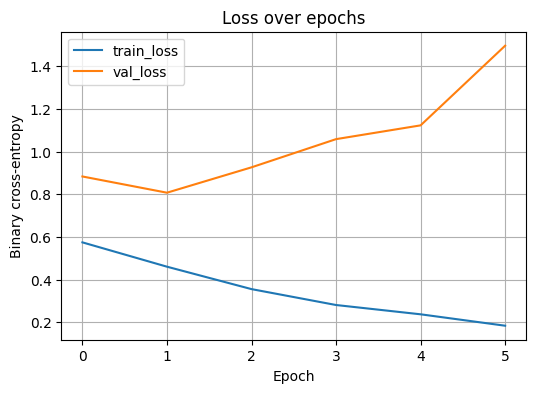

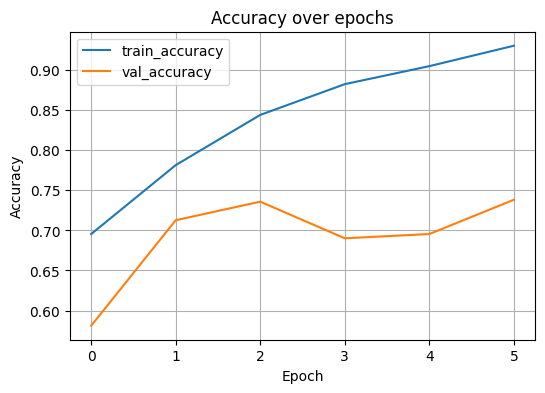

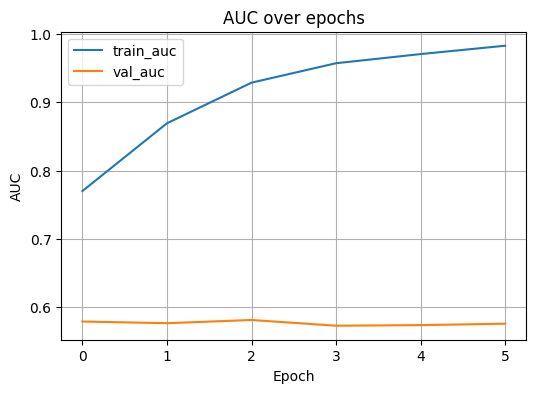

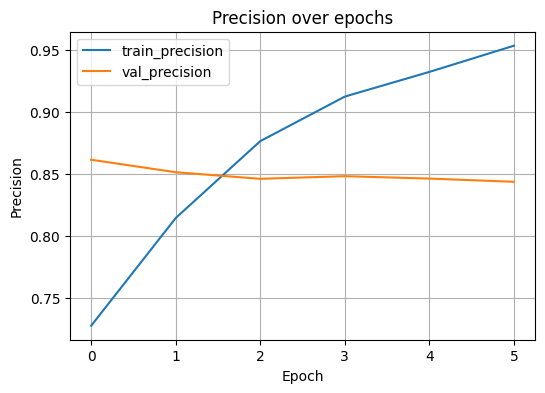

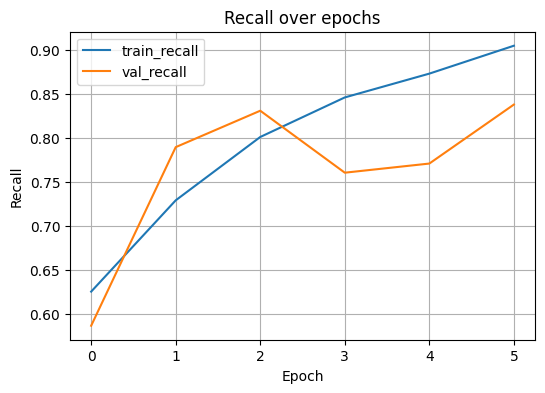

Best model reloaded.


In [ ]:
# Plot training curves
def plot_curve(key, title, ylabel):
    plt.figure()
    plt.plot(history.history[key], label=f"train_{key}")
    plt.plot(history.history[f"val_{key}"], label=f"val_{key}")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_curve("loss", "Loss over epochs", "Binary cross-entropy")
plot_curve("accuracy", "Accuracy over epochs", "Accuracy")
plot_curve("auc", "AUC over epochs", "AUC")
plot_curve("precision", "Precision over epochs", "Precision")
plot_curve("recall", "Recall over epochs", "Recall")

# Load the best model weights (EarlyStopping already restored, but this ensures exact best)
best_model = tf.keras.models.load_model("/content/bilstm_best.keras")
print("Best model reloaded.")

Evaluate on the test set (classification report, confusion matrix, ROC/PR curves)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'gmp' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Test shape: (24034, 279)
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

=== Metrics @ 0.50 threshold ===
Accuracy : 0.7384538570358659
ROC AUC  : 0.5964837014656413
PR  AUC  : 0.8655392696268047

Classification report (0.50):
              precision    recall  f1-score   support

           0     0.2700    0.2892    0.2793      4211
           1     0.8467    0.8339    0.8402     19823

    accuracy                         0.7385     24034
   macro avg     0.5584    0.5616    0.5598     24034
weighted avg     0.7457    0.7385    0.7420     24034

Confusion matrix (0.50):
[[ 1218  2993]
 [ 3293 16530]]

Best threshold by F1: 0.0018  (F1=0.9040)
Best threshold by Youden's J: 0.8911  (J=0.1473)

=== Metrics @ threshold=0.0018 ===
Accuracy : 0.824789881001914
Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4211
           1     0.8248    1.0000    0.9040     19823

    accuracy                         0.8248     2403

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


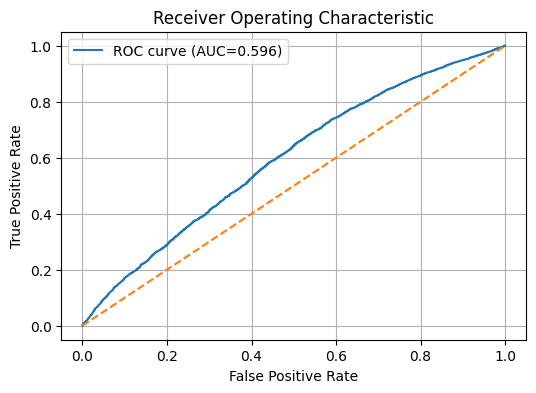

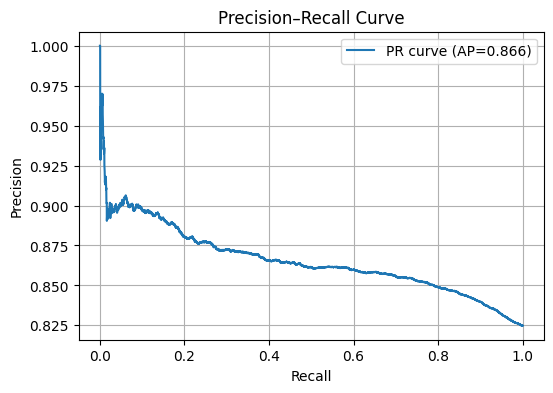

In [ ]:

import numpy as np, json, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)

# Load best model & data
best_model = tf.keras.models.load_model("/content/bilstm_best.keras")

SEQ = np.load("/content/seq_data.npz")
X_test = SEQ["X_test"]; y_test = SEQ["y_test"].astype(int)
# Map {-1,1} -> {0,1}
y_test_bin = np.where(y_test==1, 1, 0)

print("Test shape:", X_test.shape)

# Predict probabilities
y_prob = best_model.predict(X_test, batch_size=1024, verbose=1).ravel()

# Baseline metrics @ threshold=0.50
thr_default = 0.50
y_pred_05 = (y_prob >= thr_default).astype(int)

print("\n=== Metrics @ 0.50 threshold ===")
print("Accuracy :", (y_pred_05 == y_test_bin).mean())
print("ROC AUC  :", roc_auc_score(y_test_bin, y_prob))
print("PR  AUC  :", average_precision_score(y_test_bin, y_prob))

print("\nClassification report (0.50):")
print(classification_report(y_test_bin, y_pred_05, digits=4))

print("Confusion matrix (0.50):")
print(confusion_matrix(y_test_bin, y_pred_05))

# Threshold search — maximize F1 and Youden's J
prec, rec, thr_pr = precision_recall_curve(y_test_bin, y_prob)
f1_scores = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx_f1 = f1_scores.argmax()
best_thr_f1 = thr_pr[max(best_idx_f1-1, 0)]  # thr_pr has len-1 vs prec/rec

fpr, tpr, thr_roc = roc_curve(y_test_bin, y_prob)
youden = tpr - fpr
best_idx_j = youden.argmax()
best_thr_j = thr_roc[best_idx_j]

print(f"\nBest threshold by F1: {best_thr_f1:.4f}  (F1={f1_scores[best_idx_f1]:.4f})")
print(f"Best threshold by Youden's J: {best_thr_j:.4f}  (J={youden[best_idx_j]:.4f})")

def eval_at(thr):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n=== Metrics @ threshold={thr:.4f} ===")
    print("Accuracy :", (y_pred == y_test_bin).mean())
    print("Classification report:")
    print(classification_report(y_test_bin, y_pred, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_test_bin, y_pred))

eval_at(best_thr_f1)
eval_at(best_thr_j)

# Plots — ROC & PR curves
# ROC
roc_auc = roc_auc_score(y_test_bin, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PR
ap = average_precision_score(y_test_bin, y_prob)
plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP={ap:.3f})")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
